In [1]:
%matplotlib inline

from pathlib import Path
from collections import namedtuple
import numpy as np
import scipy.stats as sstats
import matplotlib.pyplot as plt
import h5py

In [2]:
datafile = Path("analyzed-data.h5")

In [3]:
logfile = "stats.md"

with open(logfile, "w") as out:
    print(f"# Statistics\n", file=out)

def log(msg):
    with open(logfile, "a") as out:
        print(msg, file=out)
    print(msg)

# Parse single video results

In [4]:
data = h5py.File(str(datafile), "r")

In [5]:
[k for k in data.keys()]

['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030']

In [6]:
video = data["001"]

In [7]:
[k for k in video.keys()]

['conditional', 'densities', 'evaluation', 'pose']

In [8]:
[f"{k}={v}" for k, v in video.attrs.items()]

['expression=coords.Tip2 < 300',
 'px_per_mm=8.4',
 'run=151428',
 'session=2020-09-11-test',
 'subject=MLA-041630']

In [9]:
cond = video["conditional"]

In [10]:
[k for k in cond.keys()]

['positions', 'probability', 'sigmoid']

In [11]:
[f"{k}={repr(v)}" for k, v in cond.attrs.items()]

['cutoff_density_count=3',
 "description='conditional probability of the real-time trigger at the given post-hoc position-values.'",
 'original_target_position_px=300']

In [12]:
sig = cond["sigmoid"]
[f"{k}={repr(v)}" for k, v in sig.attrs.items()]

["description='the results of the sigmoid fitting to the conditional probability distribution.'",
 'mean=307.90606875565913',
 'sign=-1',
 'std=18.217868298583625']

In [13]:
diff = np.array(video["evaluation/realtime"]) - np.array(video["evaluation/posthoc"])

In [14]:
np.abs(diff).mean(), diff.std(ddof=1)

(11.651634052017078, 32.435388738211955)

In [15]:
[k for k in video["pose/realtime/jump"].attrs.keys()]

['Tip1', 'Tip2', 'Tip3', 'description', 'threshold_mm', 'unit']

In [16]:
class TargetStats(namedtuple("Stats", ("original", "pos_error", "sign", "mean", "std",
                                       "subject", "session", 
                                       "Tip1diff", "Tip2diff", "Tip3diff",
                                       "Tip1jump", "Tip2jump", "Tip3jump"))):
    @classmethod
    def from_video(cls, video):
        target = video["conditional"].attrs["original_target_position_px"]
        error  = np.abs(np.array(video["evaluation/realtime"]) - np.array(video["evaluation/posthoc"])).mean()
        sig    = video["conditional/sigmoid"]
        mean   = sig.attrs["mean"]
        std    = sig.attrs["std"]
        sign   = sig.attrs["sign"]
        scale  = video.attrs["px_per_mm"]
        
        info   = [video.attrs["subject"], video.attrs["session"]]
        diffs  = []
        jumps  = []
        for attr in ("Tip1", "Tip2", "Tip3"):
            diff = np.abs(np.array(video[f"pose/realtime/{attr}"]) - np.array(video[f"pose/posthoc/{attr}"])).mean()
            diffs.append(diff / scale)
            jumps.append(video[f"pose/realtime/jump"].attrs[attr])
        return cls(target/scale, error/scale, sign, mean/scale, std/scale, *(info + diffs + jumps))
    
    @classmethod
    def merge(cls, values):
        return cls(*[np.array([getattr(v, attr) for v in values]) for attr in cls._fields])

In [17]:
TargetStats.from_video(video)

TargetStats(original=35.714285714285715, pos_error=1.387099291906795, sign=-1, mean=36.6554843756737, std=2.1687938450694793, subject='MLA-041630', session='2020-09-11-test', Tip1diff=1.0850558756616173, Tip2diff=1.387099291906795, Tip3diff=1.6605526471279732, Tip1jump=0.887719298245614, Tip2jump=0.9374800637958532, Tip3jump=0.8590111642743221)

In [18]:
data.close()

# Summarize all videos

In [19]:
with h5py.File(str(datafile), "r") as src:
    results = TargetStats.merge([TargetStats.from_video(src[videoindex]) for videoindex in src.keys()])

In [20]:
results

TargetStats(original=array([35.71428571, 35.71428571, 23.80952381, 23.80952381, 23.80952381,
       29.76190476, 23.80952381, 23.80952381,  9.52380952, 35.71428571,
       30.76923077, 14.42307692, 31.73076923, 36.53846154, 14.42307692,
       33.65384615, 14.42307692, 15.38461538, 26.92307692, 31.73076923,
       33.65384615, 17.30769231, 14.42307692, 28.84615385, 30.76923077,
       30.76923077, 32.69230769, 17.30769231, 19.23076923, 28.84615385]), pos_error=array([ 1.38709929,  1.06794939,  3.65677357, 13.80664483,  8.2894077 ,
        0.92417927,  3.61634059,  3.80566875,  3.50238693,  3.46352231,
        0.64711828,  0.71464402,  0.6171724 ,  0.27023297,  1.31481593,
        0.80025092,  0.7988079 ,  1.21964605,  0.30992211,  0.37613891,
        0.54170281,  1.70370626,  1.94817381,  0.51719482,  0.91036887,
        0.27187247,  0.4841196 ,  0.75321826,  0.78217209,  0.49433082]), sign=array([-1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,
        1, -1, -1, -1

In [21]:
def psign(pval, append=False):
    if pval < 0.001:
        return "***"
    elif pval < 0.01:
        return "**"
    elif pval < 0.05:
        return "*"
    else:
        return ", NS" if append == True else "NS"

In [22]:
error_merged = np.concatenate([getattr(results, f"Tip{index}diff") for index in range(1, 4)])

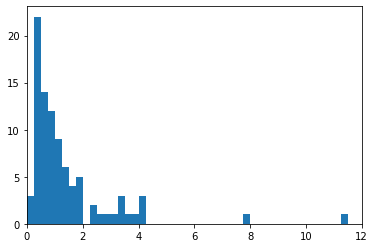

In [23]:
_ = plt.hist(error_merged, bins=80, range=(0, 20))
_ = plt.xlim(0, 12)

In [24]:
threshold = 2
tip1_good = results.Tip1diff < threshold
tip2_good = results.Tip2diff < threshold
tip3_good = results.Tip3diff < threshold

position_good = tip2_good
spread_good   = np.logical_and(tip1_good, tip3_good)

np.count_nonzero(position_good), np.count_nonzero(spread_good)

(27, 21)

## Estimation errors (real-time vs post-hoc, by part; non-filtered)

N=30 videos (7 sessions from 6 subjects).

- Tip1: 1.7361±2.5146 mm, min 0.1522 mm, max 11.4955 mm, median 0.7247 mm, 25% 0.3246 mm, 75% 2.2450 mm
- Tip2: 1.0142±0.9606 mm, min 0.2702 mm, max 4.0401 mm, median 0.7237 mm, 25% 0.4867 mm, 75% 1.0177 mm
- Tip3: 1.4132±0.8350 mm, min 0.3512 mm, max 3.8823 mm, median 1.3191 mm, 25% 0.7531 mm, 75% 1.8012 mm
- Tip1 vs Tip2: p=0.23593998, NS (Wilcoxon's signed-rank test with Bonferroni correction)
- Tip2 vs Tip3: p=0.00359201** (Wilcoxon's signed-rank test with Bonferroni correction)
- Tip1 vs Tip3: p=1.28529009, NS (Wilcoxon's signed-rank test with Bonferroni correction)



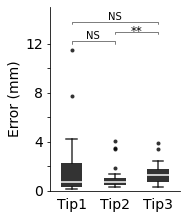

In [25]:
labelsize   = 14
linewidth   = 1.5
medianwidth = 1.5
parts = ("Tip1", "Tip2", "Tip3")
color = "k"

fig = plt.figure(figsize=(3, 3))
for i, part in enumerate(parts, start=1):
    plt.boxplot(getattr(results, f"{part}diff"), positions=(i,), 
                widths=(0.5,),
                showfliers=True,
                patch_artist=True,
                capprops=dict(linewidth=linewidth, color=color, alpha=.8),
                boxprops=dict(linewidth=0, color=color, facecolor=color, alpha=.8),
                whiskerprops=dict(linewidth=linewidth, color=color, alpha=.8),
                flierprops=dict(marker="o", mfc=color, mec="none", alpha=.8, ms=4),
                medianprops=dict(linewidth=medianwidth, color="w")
               )
log(f"## Estimation errors (real-time vs post-hoc, by part; non-filtered)\n")
subjects = set(sub for sub in results.subject)
sessions = set((sub, ses) for sub, ses in zip(results.subject, results.session))
log(f"N={results.subject.size} videos ({len(sessions)} sessions from {len(subjects)} subjects).\n")

for part in parts:
    v = getattr(results, f"{part}diff")
    log(f"- {part}: {v.mean():.4f}±{v.std(ddof=1):.4f} mm, " + \
        f"min {v.min():.4f} mm, max {v.max():.4f} mm, " + \
        f"median {np.median(v):.4f} mm, 25% {np.percentile(v, 25):.4f} mm, 75% {np.percentile(v, 75):.4f} mm")
for h, (i, j) in enumerate(((0, 1), (1, 2), (0, 2))):
    part1, part2 = parts[i], parts[j]
    values1, values2 = getattr(results, f"{part1}diff"), getattr(results, f"{part2}diff")
    p = sstats.wilcoxon(values1, values2).pvalue * 3
    log(f"- {part1} vs {part2}: p={p:.8f}{psign(p, append=True)} (Wilcoxon's signed-rank test with Bonferroni correction)")
    xbottom = 12 + 0.8 * h
    xtop = xbottom + 0.2
    plt.gca().plot((i+1,i+1,j+1,j+1), (xbottom, xtop, xtop, xbottom), "k-", lw=0.5)
    if p < 0.05:
        plt.text((i+j)/2 + 1, xtop - 0.5, psign(p), fontsize=labelsize-2, ha="center", va="bottom")
    else:
        plt.text((i+j)/2 + 1, xtop, psign(p), fontsize=labelsize-4, ha="center", va="bottom")
plt.ylim(0, 15)
plt.xlim(0.5, 3.5)
plt.xticks((1, 2, 3), parts)
plt.yticks((0, 2, 4, 6, 8, 10, 12), ("0", "", "4", "", "8", "", "12"))
plt.ylabel("Error (mm)", fontsize=labelsize)
for side in ("top", "right", ):
    plt.gca().spines[side].set_visible(False)
plt.tick_params(labelsize=labelsize, bottom=False)
plt.subplots_adjust(bottom=.15, left=.3, right=.9, top=1)

outdir = Path("F04_summary")
name   = "part-error"
if not outdir.exists():
    outdir.mkdir(parents=True)
fig.savefig(str(outdir / f"{name}.png"), dpi=400)
fig.savefig(str(outdir / f"{name}.svg"))

log("")

In [26]:
EvalType = namedtuple("EvalType", ("name", "valid", "mask", "color"))

position = EvalType("Position", np.logical_and(position_good, results.sign < 0), results.sign < 0, "m")
spread   = EvalType("Spread", np.logical_and(spread_good, results.sign > 0), results.sign > 0, "g")
evs      = (position, spread)

log("## Sessions used for accuracy evaluation\n")
log(f"the following analyses were restricted to videos where the estimation error of the related tip(s) was below {threshold:.1f} mm/frame.\n")

# count N
overlap = set((sub, sess) for sub, sess in zip(results.subject, results.session))
for evt in evs:
    log(f"### {evt.name}\n")
    subjects = set(sub for sub in results.subject[evt.valid])
    sessions = set((sub, sess) for sub, sess in zip(results.subject[evt.valid], results.session[evt.valid]))
    overlap = overlap & sessions
    log(f"N={np.count_nonzero(evt.valid)} videos ({len(sessions)} sessions from {len(subjects)} subjects):\n")
    for sess in sorted(set((sub, sess) for sub, sess in zip(results.subject, results.session)),
                       key=lambda sess: sess[0]):
        _valid = [(sub, ses) for sub, ses in zip(results.subject[evt.valid], results.session[evt.valid]) \
                  if (sub, ses) == sess]
        _total = [(sub, ses) for sub, ses in zip(results.subject[evt.mask], results.session[evt.mask]) \
                  if (sub, ses) == sess]
        _num   = "" if len(_total) == 1 else "s"
        log(f"- {sess[0]}/{sess[1]} ({len(_valid)}/{len(_total)} video{_num})")
    log("")

log("### Sessions where both position- and spread-based triggering were valid\n")
subjects = set(sess[0] for sess in overlap)
counted  = np.logical_or(position.mask, spread.mask)
runs     = [(sub, sess) for sub, sess in zip(results.subject[counted], results.session[counted])\
            if (sub, sess) in overlap]
log(f"N={len(runs)} videos ({len(overlap)} sessions from {len(subjects)} subjects):\n")
for sess in overlap:
    _valid = [(sub, ses) for sub, ses in zip(results.subject[counted], results.session[counted]) \
              if (sub, ses) == sess]
    _total = [(sub, ses) for sub, ses in zip(results.subject, results.session) \
              if (sub, ses) == sess]
    _num   = "" if len(_total) == 1 else "s"
    log(f"- {sess[0]}/{sess[1]} ({len(_valid)}/{len(_total)} video{_num})")
log("")

## Sessions used for accuracy evaluation

the following analyses were restricted to videos where the estimation error of the related tip(s) was below 2.0 mm/frame.

### Position

N=15 videos (6 sessions from 5 subjects):

- MLA-041630/2020-09-11-test (2/2 videos)
- S005-19/2020-09-11-test (1/1 video)
- S006-19/2020-09-11-test (0/1 video)
- SNA-079258/2020-12-06-test (3/3 videos)
- SNA-079258/2020-12-07-test (2/2 videos)
- SNA-079259/2020-12-11-test (3/3 videos)
- SNA-079260/2020-12-11-test (4/4 videos)

### Spread

N=8 videos (4 sessions from 3 subjects):

- MLA-041630/2020-09-11-test (0/3 videos)
- S005-19/2020-09-11-test (0/1 video)
- S006-19/2020-09-11-test (0/2 videos)
- SNA-079258/2020-12-06-test (2/2 videos)
- SNA-079258/2020-12-07-test (2/2 videos)
- SNA-079259/2020-12-11-test (2/2 videos)
- SNA-079260/2020-12-11-test (2/2 videos)

### Sessions where both position- and spread-based triggering were valid

N=20 videos (4 sessions from 3 subjects):

- SNA-079258/2020-12-07-test (4/

## Evaluation of real-time accuracy

### Threshold positions in real-time triggering

- Position: -0.1765±0.4356 mm, min -0.8139 mm, max 0.9412 mm, median -0.2135 mm, 25% -0.3926 mm, 75% -0.1077; p=0.06372070, NS (Wilcoxon's signed-rank test)
- Spread: 1.0968±0.9063 mm, min 0.1475 mm, max 2.4381 mm, median 0.6312 mm, 25% 0.4691 mm, 75% 1.8488; p=0.00781250** (Wilcoxon's signed-rank test)
- Position vs Spread: p=0.00044319*** (Mann-Whitney's U-test)



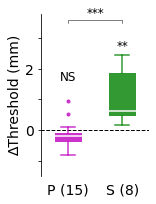

In [27]:
delta = results.mean - results.original
labelsize   = 14
linewidth   = 1.5
medianwidth = 1.5

log("## Evaluation of real-time accuracy\n")

log("### Threshold positions in real-time triggering\n")

fig = plt.figure(figsize=(2.5, 3))
for i, ev in enumerate(evs, start=1):
    v = delta[ev.valid]
    plt.boxplot(v, positions=(i,), 
                widths=(0.5,),
                showfliers=True,
                patch_artist=True,
                capprops=dict(linewidth=linewidth, color=ev.color, alpha=.8),
                boxprops=dict(linewidth=0, color=ev.color, facecolor=ev.color, alpha=.8),
                whiskerprops=dict(linewidth=linewidth, color=ev.color, alpha=.8),
                flierprops=dict(marker="o", mfc=ev.color, mec="none", alpha=.8, ms=4),
                medianprops=dict(linewidth=medianwidth, color="w")
               )
    p = sstats.wilcoxon(results.mean[ev.valid], results.original[ev.valid]).pvalue
    log(f"- {ev.name}: {v.mean():.4f}±{v.std(ddof=1):.4f} mm, " + \
        f"min {v.min():.4f} mm, max {v.max():.4f} mm, " + \
        f"median {np.median(v):.4f} mm, 25% {np.percentile(v, 25):.4f} mm, 75% {np.percentile(v, 75):.4f}; " + \
        f"p={p:.8f}{psign(p, append=True)} (Wilcoxon's signed-rank test)")
    if p < 0.05:
        plt.text(i, delta[ev.valid].max()+.3, psign(p), 
                 fontsize=labelsize-2, ha="center", va="center")
    else:
        plt.text(i, delta[ev.valid].max()+.8, psign(p), 
                 fontsize=labelsize-2, ha="center", va="center")
p = sstats.mannwhitneyu(delta[position.valid], delta[spread.valid]).pvalue
log(f"- Position vs Spread: p={p:.8f}{psign(p, append=True)} (Mann-Whitney's U-test)")
base = 3.5
plt.gca().plot((1,1,2,2), (base, base+.1, base+.1, base), "k-", lw=0.5)
if p < 0.05:
    plt.text(1.5, base+.1, psign(p), fontsize=labelsize-2, ha="center", va="bottom")
else:
    plt.text(1.5, base+.1, psign(p), fontsize=labelsize-2, ha="center", va="bottom")
plt.hlines(0, 0, 3, linestyle="--", linewidth=1, color="k")
plt.ylim(-1.5, 3.8)
plt.xlim(0.5, 2.5)
plt.xticks((1, 2), [f"{ev.name[0]} ({np.count_nonzero(ev.valid)})" for ev in evs])
plt.yticks((-1, 0, 1, 2, 3), ("", "0", "", "2", "", ))
plt.ylabel("∆Threshold (mm)", fontsize=labelsize)
for side in ("top", "right", "bottom"):
    plt.gca().spines[side].set_visible(False)
plt.tick_params(labelsize=labelsize, bottom=False)
plt.subplots_adjust(bottom=.15, left=.3, right=.9, top=0.9)

outdir = Path("F04_summary")
name   = "threshold-difference"
if not outdir.exists():
    outdir.mkdir(parents=True)
fig.savefig(str(outdir / f"{name}.png"), dpi=400)
fig.savefig(str(outdir / f"{name}.svg"))

log("")

### Threshold variability in real-time triggering

- Position: 1.5940±1.0531 mm, min 0.9062 mm, max 4.3376 mm, median 1.0943 mm, 25% 1.0314 mm, 75% 1.4161 mm
- Spread: 3.6876±1.8970 mm, min 1.9493 mm, max 7.4774 mm, median 3.3360 mm, 25% 2.2116 mm, 75% 4.1485 mm
- Position vs Spread: p=0.00134299** (Mann-Whitney's U-test)



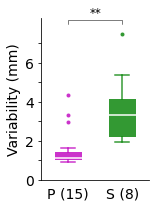

In [28]:
labelsize   = 14
linewidth   = 1.5
medianwidth = 1.5

acc = results.std * 2

log("### Threshold variability in real-time triggering\n")

fig = plt.figure(figsize=(2.5, 3))
for i, ev in enumerate(evs, start=1):
    mwidth = medianwidth
    v = acc[ev.valid]
    log(f"- {ev.name}: {v.mean():.4f}±{v.std(ddof=1):.4f} mm, " + \
        f"min {v.min():.4f} mm, max {v.max():.4f} mm, " + \
        f"median {np.median(v):.4f} mm, 25% {np.percentile(v, 25):.4f} mm, 75% {np.percentile(v, 75):.4f} mm")
    plt.boxplot(v, positions=(i,), 
                widths=(0.5,),
                showfliers=True,
                patch_artist=True,
                capprops=dict(linewidth=linewidth, color=ev.color, alpha=.8),
                boxprops=dict(linewidth=0, color=ev.color, facecolor=ev.color, alpha=.8),
                whiskerprops=dict(linewidth=linewidth, color=ev.color, alpha=.8),
                flierprops=dict(marker="o", mfc=ev.color, mec="none", alpha=.8, ms=4),
                medianprops=dict(linewidth=mwidth, color="w")
               )
p = sstats.mannwhitneyu(acc[position.valid], acc[spread.valid]).pvalue
log(f"- Position vs Spread: p={p:.8f}{psign(p, append=True)} (Mann-Whitney's U-test)")
plt.gca().plot((1,1,2,2), (8, 8.2, 8.2, 8), "k-", lw=0.5)
if p < 0.05:
    plt.text(1.5, 8.2, psign(p), fontsize=labelsize-2, ha="center", va="bottom")
plt.ylim(0, 8.3)
plt.xlim(0.5, 2.5)
plt.xticks((1, 2), [f"{ev.name[0]} ({np.count_nonzero(ev.valid)})" for ev in evs])
plt.yticks((0, 1, 2, 3, 4, 5, 6, 7), ("0", "", "2", "", "4", "", "6", ""))
plt.ylabel("Variability (mm)", fontsize=labelsize)
for side in ("top", "right",):
    plt.gca().spines[side].set_visible(False)
plt.tick_params(labelsize=labelsize, bottom=False)
plt.subplots_adjust(bottom=.15, left=.3, right=.9, top=0.9)

outdir = Path("F04_summary")
name   = "variability"
if not outdir.exists():
    outdir.mkdir(parents=True)
fig.savefig(str(outdir / f"{name}.png"), dpi=400)
fig.savefig(str(outdir / f"{name}.svg"))

log("")